Сначала отбираем гены, которые встречаются при определённых заболеваниях (БА, ПД, БАС), а так же их индексы встречаемости с помощью кода ниже

In [ ]:
data_path = '/Volumes/chuudisuko/0cyto/для диплома/CTD_genes_diseases.csv'
# Боковой амиотрофический склероз, болезнь Альцгеймера, и болезнь Паркинсона
check_list = ['MESH:D000690', 'MESH:D000544', 'MESH:D010300']
d = {k:{} for k in check_list}
with open(data_path, 'r') as f:
    for n, line in enumerate(f):
        first_sym = line[0]
        # в начале файла присутствуют комментарии
        if first_sym == '#':
                pass
        else:
                d_list = line.split(',')
                id = d_list[3]
                if id in check_list:
                        gene, score = d_list[1], d_list[-3]
                        cur_vals = d[id]
                        if gene not in cur_vals:
                                cur_vals[gene] = score
        cur_n = n%2000000
        if not cur_n:
                print(f'Current number of row is {n}')

Далее есть смысл отсортировать по значениям ключей словаря

In [64]:
d_n = {}
for key, val in d.items():
    cur_k = d_n[key] = {}
    for val_key, val_val in val.items():
        if val_val != '':
            int_k = int(val_key)
            cur_k[int_k] = float(val_val)

In [65]:
for key, val in d_n.items():
    d_n[key] = dict(sorted(val.items(), key=lambda item: item[1], reverse=True))

In [55]:
d_n

{'MESH:D000690': {847: 118.79,
  3162: 105.42,
  836: 101.13,
  2876: 98.01,
  4843: 97.68,
  351: 97.66,
  3569: 97.22,
  3553: 96.03,
  7124: 92.64,
  581: 92.47,
  7040: 92.4,
  3458: 91.47,
  842: 91.3,
  3309: 88.48,
  213: 88.12,
  596: 86.03,
  3725: 85.66,
  2353: 85.24,
  3586: 82.8,
  4846: 82.1,
  3558: 81.67,
  3952: 80.81,
  1401: 80.36,
  54205: 79.99,
  207: 79.56,
  3565: 79.48,
  834: 79.4,
  2932: 78.31,
  142: 77.28,
  1499: 77.05,
  627: 75.37,
  2729: 75.19,
  5595: 75.02,
  17748: 74.8,
  1543: 74.71,
  6347: 73.87,
  5970: 73.52,
  5111: 72.5,
  7422: 72.17,
  5594: 71.62,
  1728: 71.4,
  7132: 70.97,
  4313: 70.9,
  4790: 70.21,
  949: 69.76,
  3479: 68.94,
  2475: 68.18,
  1385: 67.38,
  5468: 67.25,
  598: 67.2,
  5465: 67.0,
  595: 66.73,
  23411: 66.68,
  4842: 66.38,
  2944: 65.92,
  3972: 65.77,
  1244: 65.21,
  4288: 64.81,
  2697: 64.39,
  7296: 63.97,
  8743: 63.86,
  841: 63.84,
  840: 63.61,
  6352: 63.61,
  3576: 62.9,
  43: 62.82,
  5617: 62.79,
  6

нужно получить список ключей и передать его в установщик NCBI

Отбираем только первый 1% данных (около 260 генов для каждой нозологии)

In [82]:
raw_short_d = {k:list(d_n[k].values())[:len(d_n[k].values())//100] for k in check_list}

In [85]:
short_d = {}
for k, v in raw_short_d.items():
    cur_sh = short_d[k] = {}
    for key, val in zip(d_n[k].keys(), v):
        cur_sh[key] = val

In [66]:
import pickle
with open('/Users/watashicuvu/Downloads/filt_data.pkl','wb') as f:
    pickle.dump(d_n, f)

In [88]:
import pickle
with open('/Users/watashicuvu/Downloads/short_filt_data.pkl','wb') as f:
    pickle.dump(short_d, f)

In [67]:
import pickle
with open('/Users/watashicuvu/Downloads/filt_data.pkl','rb') as f:
    d_n = pickle.load(f)

In [1]:
import pickle
with open('/Users/watashicuvu/Downloads/short_filt_data.pkl','rb') as f:
    s_d_n = pickle.load(f)

https://www.insdc.org

https://blast.ncbi.nlm.nih.gov/doc/blast-help/downloadblastdata.html


Далее нужно спарсить данные с NCBI .fna и .faa. Я сделаю это вручную, так как готовые решения не очень удобны для меня

In [3]:
def cook_seq(s_r):
    ac_d = {}
    for s in s_r[1:]:
        f_n = True
        raw_key, nucl = '', ''
        for sym in s:
            if f_n and sym != '\n':
                raw_key += sym
            elif f_n and sym == '\n':
                f_n = False
            elif not f_n and sym != '\n':
                nucl += sym
        raw_key_char = raw_key.split(' ')
        char = raw_key_char[-1]
        gene = raw_key_char[1]
        last_seam = char[1]
        if last_seam!='G':
            if gene not in ac_d:
                ac_d[gene] = {}
            ac_d[gene][char] = nucl
        else:
            ac_d[gene] = {'[alone]':nucl}
    return ac_d


In [4]:
def long_short(seq_d):
    long_d, short_d = {}, {}
    for gene, seqs in seq_d.items():
        if '[alone]' in seqs:
            long_d[gene] = seqs['[alone]']
            short_d[gene] = seqs['[alone]']
        else:
            min, max = 0, 0
            for _, seq in seqs.items():
                seq_l = len(seq)
                if not min:
                    min = seq_l
                    shortest = seq
                if seq_l > max:
                    longest = seq
                elif seq_l < min:
                    shortest = seq
            long_d[gene] = longest
            short_d[gene] = shortest
    return long_d, short_d

In [60]:
path_rna = '/Volumes/chuudisuko/0cyto/для_диплома/genes/ncbi_dataset_all/ncbi_dataset/data/rna.fna'
path_prot = '/Volumes/chuudisuko/0cyto/для_диплома/genes/ncbi_dataset_all/ncbi_dataset/data/protein.faa'

with open(path_rna, 'r') as f:
    r = f.read()
    s_r = r.split('>')
    
with open(path_prot, 'r') as f:
    r = f.read()
    p_r = r.split('>')

In [61]:
pr = cook_seq(p_r)
nuc = cook_seq(s_r)

In [67]:
iso_long, iso_short = long_short(nuc)

и для РНК, и для белков; на выходе словарь ac_d с генами и их вариантами транскриптов; время исполнения для n=400 генов - 2.4 секунд

In [37]:
iso_short

{'AGT': 'MAPAGVSLRATILCLLAWAGLAAGDRVYIHPFHLVIHNESTCEQLAKANAGKPKDPTFIPAPIQAKTSPVDEKALQDQLVLVAAKLDTEDKLRAAMVGMLANFLGFRIYGMHSELWGVVHGATVLSPTAVFGTLASLYLGALDHTADRLQAILGVPWKDKNCTSRLDAHKVLSALQAVQGLLVAQGRADSQAQLLLSTVVGVFTAPGLHLKQPFVQGLALYTPVVLPRSLDFTELDVAAEKIDRFMQAVTGWKTGCSLMGASVDSTLAFNTYVHFQGKMKGFSLLAEPQEFWVDNSTSVSVPMLSGMGTFQHWSDIQDNFSVTQVPFTESACLLLIQPHYASDLDKVEGLTFQQNSLNWMKKLSPRTIHLTMPQLVLQGSYDLQDLLAQAELPAILHTELNLQKLSNDRIRVGEVLNSIFFELEADEREPTESTQQLNKPEVLEVTLNRPFLFAVYDQSATALHFLGRVANPLSTA',
 'MMP1': 'MQEFFGLKVTGKPDAETLKVMKQPRCGVPDVAQFVLTEGNPRWEQTHLTYRIENYTPDLPRADVDHAIEKAFQLWSNVTPLTFTKVSEGQADIMISFVRGDHRDNSPFDGPGGNLAHAFQPGPGIGGDAHFDEDERWTNNFREYNLHRVAAHELGHSLGLSHSTDIGALMYPSYTFSGDVQLAQDDIDGIQAIYGRSQNPVQPIGPQTPKACDSKLTFDAITTIRGEVMFFKDRFYMRTNPFYPEVELNFISVFWPQLPNGLEAAYEFADRDEVRFFKGNKYWAVQGQNVLHGYPKDIYSSFGFPRTVKHIDAALSEENTGKTYFFVANKYWRYDEYKRSMDPGYPKMIAHDFPGIGHKVDAVFMKDGFFYFFHGTRQYKFDPKTKRILTLQKANSWFNCRKN',
 'HSPA5': 'MKLSLVAAMLLLLSAARAEEEDKKEDVGTVVGIDLGTTYSCVGVFKNGRVEIIANDQGNRITPSYVAFTPEGERLIGDAAKNQLT

Далее следует код по вычислению сложности последовательности. Во-первых, лингвистической. Максимальное количество слов - это минимум между числом комбинаций длиной i и величиной N-i+1 

In [5]:
# 4 нуклеотида; # 20 АМК
def max_len(num, comb = 4):
    '''num - len of seq'''
    accum = []
    for i in range(1,num+1):
        quant = num - i + 1
        if quant > comb:
            accum.append(comb)
            comb *= 4
        else:
            accum.append(quant)
    return accum

In [6]:
import numpy as np

def count_compl(ss):
    d = {}
    ling_comp = []
    ent_comp = []
    s_l = len(ss)
    for s in range(1, s_l+1):
        if s < s_l//2:
            rr = range(s)
        else:
            rr = range(s_l-s+1)
        if s not in d:
                d[s] = {}
                d_m = {}
        cur_d = d[s]
        for j in rr:  
            for s1, s2 in zip(range(j, s_l, s), range(j+s-1, s_l, s)):
                word = ss[s1:s2+1]
                if word not in d_m:
                    cur_d[word] = 1
                    d_m[word] = 1
                else:
                    d_m[word] += 1
            for w, v in d_m.items():
                if v >= cur_d[w]:
                    cur_d[w] = v
            d_m[word] = 0
        d_m = {}

        ling_comp.append(len(cur_d))
        values = cur_d.values()
        p = sum(values)
        ent_sum = 0
        cur_base = np.log(len(cur_d))
        for val in values:
            p_s = val / p
            log_p_s, log_s = np.log(p_s), cur_base
            lg_p_s = log_p_s / log_s
            ent_sum += lg_p_s*p_s
        ent_comp.append(-1*ent_sum)
        m_v = max(cur_d.values())
        if m_v == 1:
            break   
    return ling_comp, ent_comp

In [7]:
def d_out_gen(iso):
    d = {}
    for key, value in iso.items():
        cur_k = d[key] = {}
        ling_comp, ent_comp = count_compl(value)
        m_l = max_len(len(value), comb = 20)
        q_sum1 = sum(m_l[:len(ling_comp)])
        q_sum2 = sum(m_l[len(ling_comp):])
        q_comp = sum(ling_comp)/q_sum1
        f_comp = 1 - sum(ling_comp)/(q_sum1+q_sum2)
        cur_k['ent'] = ent_comp
        cur_k['q_ling_comp'] = q_comp
        cur_k['full_ling_comp'] = f_comp
    return d


239 генов за 43 - 46.6 секунды.
239 транскриптов за 1.6 секунды

In [71]:
d_out = d_out_gen(iso_short)

{'PPARA': {'ent': [0.9992551877788488,
   0.9871923102936101,
   0.9831044565115309,
   0.9782346173324385,
   0.9718684905600002,
   0.9723220082310621,
   0.984443135258959,
   0.9936812647268864,
   0.9974492187855397,
   0.9987457849285499,
   0.9992484036987866,
   0.9994677346724952,
   0.9995783224603455,
   0.9996599303920493,
   0.9997284804239752,
   0.9997846279357662,
   0.9998300158601143,
   0.999855452628341,
   0.9998809020655354,
   0.9999042890412617,
   0.9999237175285153,
   0.9999405488273623,
   0.9999573869291167,
   0.9999707287414323,
   0.9999840767630382,
   0.9999920357348706,
   0.9999999999998415],
  'q_ling_comp': 0.920908711998417,
  'full_ling_comp': 0.9960305829684413},
 'POMC': {'ent': [0.9600998613564372,
   0.9434548417764682,
   0.9408184146336842,
   0.9381577396107388,
   0.962538086403136,
   0.9816534698353832,
   0.9924663534319319,
   0.9964057553908144,
   0.9980099781804155,
   0.9986290070933771,
   0.9990251036534858,
   0.999234383414394

In [ ]:
import pickle
with open('/Users/watashicuvu/Downloads/short_iso_nucl_union_data.pkl','wb') as f:
    pickle.dump(d_out, f)

пример команды для скачивания отобранных генов

conda activate ncbi_datasets

datasets download gene gene-id 847 581 5617 3553 596 4780 836 3458 1958 1385 2936 43 2353 5595 842 213 5594 4843 5743 5970 3725 7157 7422 840 351 7040 4790 355 207 1312 834 5468 3952 5599 114548 3576 23657 2099 3309 3586 664 3479 2952 2475 811 8878 6582 1277 1544 6347 2354 6696 1843 2597 948 6352 2902 1814 100506742 4155 3552 2932 54205 2194 2729 183 598 1051 2697 4792 3164 2923 3726 20249 1401 1026 2879 4353 1649 5315 5465 7099 5111 2908 23411 6590 367 5580 112399 2875 6720 17748 60 2878 7077 1499 7001 1543 27113 3315 5621 2023 572 30061 48 2170 6863 8408 7494 249 100506658 5604 4609 467 9516 1508 1576 2247 17750 5054 3667 142 7132 5601 6275 3091 7046 81631 5443 2335 595 5742 7128 2730 59 19 133 654 1509 10397 801 5997 9133 4846 3565 1462 5562 2539 301 29108 4233 5444 8678 84448 1432 653361 857 1786 4783 841 10935 26471 9588 4804 5447 10018 1374 6770 5566 5179 4915 9131 472 3558 891 216 135 6513 7412 6507 9817 6446 16333 701 4953 1437 8863 637 2938 4852 3627 526 2069 348 3606 498 10457 5228 316 4929 31 5037 211 3551 3422 823 629 8654 590 7538 5792 9709 332 1392 55022 7296 440 7082 5052 3684 6348 10135 5704 7037 4288 10403 999 7249 604 7042 6272 3312 3949 7430 1965 949 4170 3304 5366 10460 353322 6774 2643 272 9636 5798 3157 4023 3925 3398 7170 208 47 2946 5187 4502 2675 1627 140809 4313 1536 1915 5728 10808 3815 3383 23645 5925 1149 9314 1052 6354 3065 225 6307 4489 4691 2495 5894 1718 9615 54674 4257 1647 468 4189 51129

In [38]:
import pickle
with open('/Users/watashicuvu/Downloads/pkl-data/union/rna_union/short_iso_nucl_union_data.pkl','rb') as f:
    d_n_g = pickle.load(f)

n = 400; лучше провести БС и рассчитать ДИ

In [42]:
ent_d_g = {}
q_ling_arr_sh_g = []
f_ling_arr_sh_g = []
for vals in d_n_g.values():
    q_ling_arr_sh_g.append(vals['q_ling_comp'])
    f_ling_arr_sh_g.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_g:
            ent_d_g[n] = []
        ent_d_g[n].append(e)

(array([ 3.,  3.,  5.,  6.,  7., 13., 15., 22., 22., 24., 27., 16., 26.,
        22., 14., 25., 18., 18., 15., 10., 16., 14., 20., 12., 15., 10.,
         8.,  7.,  9.,  8.,  8.,  5.,  2.,  1.,  2.]),
 array([0.73293051, 0.73973149, 0.74653246, 0.75333343, 0.7601344 ,
        0.76693537, 0.77373634, 0.78053732, 0.78733829, 0.79413926,
        0.80094023, 0.8077412 , 0.81454218, 0.82134315, 0.82814412,
        0.83494509, 0.84174606, 0.84854703, 0.85534801, 0.86214898,
        0.86894995, 0.87575092, 0.88255189, 0.88935286, 0.89615384,
        0.90295481, 0.90975578, 0.91655675, 0.92335772, 0.9301587 ,
        0.93695967, 0.94376064, 0.95056161, 0.95736258, 0.96416355,
        0.97096453]),
 <BarContainer object of 35 artists>)

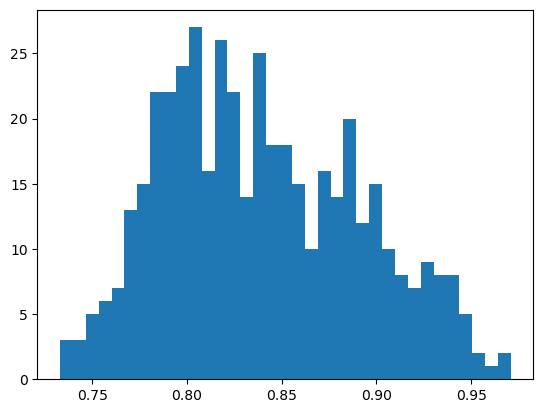

In [15]:
import matplotlib.pyplot as plt

plt.hist(q_ling_arr_sh_g, bins=35)
#plt.hist(f_ling_arr_sh_g, bins=25)

(array([ 4.,  2.,  0.,  3.,  3.,  5.,  9.,  7., 11., 18., 30., 35., 46.,
        52., 70., 56., 52., 33., 10.,  2.]),
 array([0.92219108, 0.92522133, 0.92825158, 0.93128183, 0.93431209,
        0.93734234, 0.94037259, 0.94340284, 0.94643309, 0.94946335,
        0.9524936 , 0.95552385, 0.9585541 , 0.96158436, 0.96461461,
        0.96764486, 0.97067511, 0.97370536, 0.97673562, 0.97976587,
        0.98279612]),
 [<matplotlib.patches.Polygon at 0x7fc940d9a310>])

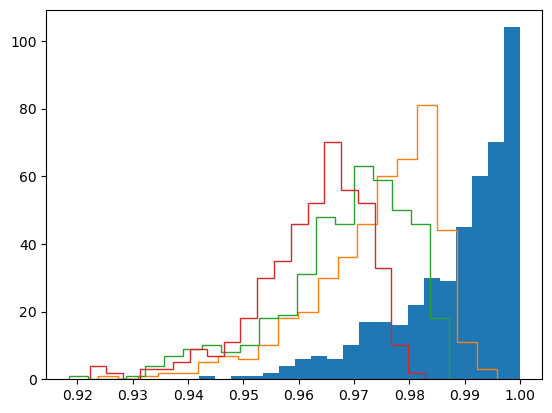

In [36]:
plt.hist(ent_d_g[0], bins=20)
plt.hist(ent_d_g[1], bins=20, histtype='step')
plt.hist(ent_d_g[2], bins=20, histtype='step')
plt.hist(ent_d_g[3], bins=20, histtype='step')
#plt.hist(ent_d_g[4], bins=25, histtype='step')
#plt.hist(ent_d_g[5], bins=25, histtype='step')

похоже на 2 пика в f_ling; и в q_ling

Можно отобрать значения из 95 ДИ слева по количеству наблюдений в ent_d

In [13]:
from scipy.stats import bootstrap
import numpy as np
data = (q_ling_arr_sh_g, )
res = bootstrap(data, np.mean, method= 'basic', confidence_level = 0.9)
data_l = (f_ling_arr_sh_g, )
res_l = bootstrap(data_l, np.mean, confidence_level = 0.9)


In [42]:
ent_len = [len(v) for v in ent_d_g.values()]

In [49]:
print(*ent_len)

448 448 448 448 448 448 448 448 448 442 424 382 320 257 220 192 162 146 120 108 91 84 71 59 50 47 44 43 38 35 33 29 28 25 25 21 19 19 14 12 11 11 9 9 8 7 7 7 6 6 6 6 6 6 6 6 6 6 4 4 4 4 4 3 3 3 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1


In [8]:
ent_bs = {}
for k,v in ent_d_g.items():
    data = (f_ling_arr_sh_g, )
    res = bootstrap(data, np.mean, confidence_level = 0.9)
    ent_bs[k] = res
    if k == 10:
        break

нужно сравнить или с данными из литературы, или довольно большой частью генов из генома человека; с белками хорошо бы так же; в данный момент вызывает подозрения, что у всех 450 генов есть последовательность из 9 одинаковых нуклеотидов (уж не старт, стоп кодоны и ещё некоторая последовательность?)

In [51]:
ent_bs

{0: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896727773838604, high=0.9908758329466686), bootstrap_distribution=array([0.99034886, 0.99081991, 0.99091477, ..., 0.99029678, 0.99093393,
        0.99022728]), standard_error=0.00036273614744153376),
 1: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896803780920527, high=0.9908914993536709), bootstrap_distribution=array([0.99036433, 0.99037494, 0.99056271, ..., 0.9891975 , 0.9903355 ,
        0.99018566]), standard_error=0.0003674812916914459),
 2: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896657764441359, high=0.9908870774687312), bootstrap_distribution=array([0.99009222, 0.99009192, 0.99012453, ..., 0.99069987, 0.99017599,
        0.99028801]), standard_error=0.0003695124916480789),
 3: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896816439252931, high=0.9908772493787051), bootstrap_distribution=array([0.99100359, 0.99008625, 0.99031073, ..., 0.99027812, 0.99021692,


In [15]:
res_l

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896812884716909, high=0.9908978771138603), bootstrap_distribution=array([0.98963968, 0.98970071, 0.99041522, ..., 0.99035796, 0.99048965,
       0.99052502]), standard_error=0.0003671578353476252)

In [14]:
res

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.8358160795406042, high=0.8437252928058423), bootstrap_distribution=array([0.83712577, 0.83775593, 0.83969681, ..., 0.83749454, 0.84120467,
       0.84056546]), standard_error=0.0024055802050427714)

Отберём 6000 генов из генома человека случайно (по-хорошему найти формулу для расчета достоверности)

In [4]:
import pandas as pd

t = pd.read_csv('/Volumes/chuudisuko/0cyto/ncbi_dataset.csv')

In [18]:
import numpy as np
g_ids = list(t['Gene ID'].values)

In [20]:
from random import sample 
# повторов не будет при использовании sample
# при использовании choices могли бы быть повторов
sel_ids = sample(g_ids, 6000)

In [ ]:
sel_ids

Отбираем 6000 случайных генов из генотипа человека

In [1]:
gene_path = '/Volumes/chuudisuko/0cyto/геном человека/GCF_000001405.40_GRCh38.p14_rna.fna'

with open(gene_path, 'r') as f:
    r = f.read()
    g_r = r.split('>')

In [11]:
from random import sample 
sel_genes = sample(g_r[1:], 6000)

In [21]:
fin_nucl_glob = {}
for n, gene in enumerate(sel_genes):
    g_ind = gene.find('\n')
    nucl = gene[(g_ind+1):].replace('\n', '')
    fin_nucl_glob[n] = nucl

In [32]:
d_out = d_out_gen(fin_nucl_glob)

KeyboardInterrupt: 

In [40]:
d = {}
for n, (key, value) in enumerate(fin_nucl_glob.items()):
    cur_k = d[key] = {}
    ling_comp, ent_comp = count_compl(value)
    m_l = max_len(len(value), comb = 20)
    q_sum1 = sum(m_l[:len(ling_comp)])
    q_sum2 = sum(m_l[len(ling_comp):])
    q_comp = sum(ling_comp)/q_sum1
    f_comp = 1 - sum(ling_comp)/(q_sum1+q_sum2)
    cur_k['ent'] = ent_comp
    cur_k['q_ling_comp'] = q_comp
    cur_k['full_ling_comp'] = f_comp
    if n%600==0:
        print(n)

0
600
1200
1800
2400
3000


KeyboardInterrupt: 

n=3214 (можно несколько раз по 3000 взять)

In [41]:
len(d)

3214

In [46]:
vals

{}

# Для генеральной совокупности

In [16]:
import pickle

with open('/Users/watashicuvu/Downloads/pkl-data/all_genome/nucl_gen_3214_data.pkl', 'rb') as f:
    d = pickle.load(f)

In [17]:
ent_d_g = {}
q_ling_arr_g = []
f_ling_arr_g = []
# list [:450] можно убрать, чтобы посмотреть ДИ для всех 3000 генов
for vals in list(d.values())[:450]:
    q_ling_arr_g.append(vals['q_ling_comp'])
    f_ling_arr_g.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_g:
            ent_d_g[n] = []
        ent_d_g[n].append(e)


(array([ 1.,  1.,  0.,  1.,  5.,  1.,  3.,  4.,  6., 13., 27., 44., 56.,
        49., 31., 39., 25., 24., 19., 26., 26., 14., 12., 14.,  9.]),
 array([0.63829787, 0.65127962, 0.66426137, 0.67724312, 0.69022487,
        0.70320662, 0.71618838, 0.72917013, 0.74215188, 0.75513363,
        0.76811538, 0.78109713, 0.79407888, 0.80706063, 0.82004238,
        0.83302413, 0.84600588, 0.85898763, 0.87196938, 0.88495113,
        0.89793288, 0.91091463, 0.92389638, 0.93687813, 0.94985988,
        0.96284163]),
 <BarContainer object of 25 artists>)

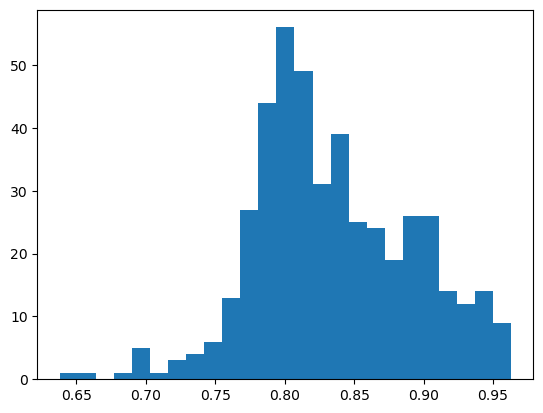

In [56]:
import matplotlib.pyplot as plt

plt.hist(q_ling_arr_g, bins=25)
#plt.hist(f_ling_arr, bins=15)

q_ling имеет два пика; f_ling тоже около двух пиков

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   1.,   4.,   4.,  19.,  28.,  51.,  86., 116.,  98.,
         27.,   4.,   9.]),
 array([0.84643525, 0.85220676, 0.85797827, 0.86374978, 0.86952129,
        0.8752928 , 0.8810643 , 0.88683581, 0.89260732, 0.89837883,
        0.90415034, 0.90992185, 0.91569336, 0.92146487, 0.92723638,
        0.93300789, 0.93877939, 0.9445509 , 0.95032241, 0.95609392,
        0.96186543, 0.96763694, 0.97340845, 0.97917996, 0.98495147,
        0.99072297]),
 [<matplotlib.patches.Polygon at 0x7fc93ae79730>])

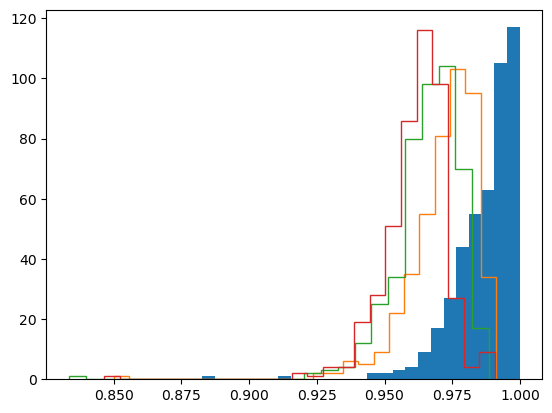

In [47]:
plt.hist(ent_d_g[0], bins=25)
plt.hist(ent_d_g[1], bins=25, histtype='step')
plt.hist(ent_d_g[2], bins=25, histtype='step')
plt.hist(ent_d_g[3], bins=25, histtype='step')
#plt.hist(ent_d_g[4], bins=25, histtype='step')
#plt.hist(ent_d_g[5], bins=25, histtype='step')

In [18]:
from scipy.stats import bootstrap
import numpy as np
data_g = (q_ling_arr_g, )
data_l_g = (f_ling_arr_g, )
res_g = bootstrap(data_g, np.mean, method= 'bca', confidence_level = 0.9)
res_long_g = bootstrap(data_l_g, np.mean, method= 'bca', confidence_level = 0.9)

In [26]:
res_g

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.8301611562130563, high=0.8389323438227173), bootstrap_distribution=array([0.83552939, 0.83151593, 0.8346884 , ..., 0.83752298, 0.83225107,
       0.84303735]), standard_error=0.002674136114109898)

In [29]:
res_long_g

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9846217387651429, high=0.9884098443164011), bootstrap_distribution=array([0.9873867 , 0.9858458 , 0.98750491, ..., 0.98654293, 0.98484871,
       0.98745501]), standard_error=0.0010708687122195583)

In [36]:
ent_bs_g = {}
for k,v in ent_d_g.items():
    data = (f_ling_arr_g, )
    res = bootstrap(data, np.mean, confidence_level = 0.9)
    ent_bs_g[k] = res
    if k == 10:
        break

In [53]:
ent_bs

{0: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9846893881048343, high=0.988413479940802), bootstrap_distribution=array([0.98735937, 0.98379349, 0.98726011, ..., 0.98748763, 0.98616345,
        0.98874858]), standard_error=0.0010686562477220855),
 1: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9847042735771773, high=0.9884267846522926), bootstrap_distribution=array([0.9875168 , 0.98800449, 0.98636513, ..., 0.98643374, 0.9885794 ,
        0.98577027]), standard_error=0.001080902685933026),
 2: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9846971416354227, high=0.9884341124709636), bootstrap_distribution=array([0.98775141, 0.98703903, 0.985456  , ..., 0.98631332, 0.98631719,
        0.98695602]), standard_error=0.0010831731611898243),
 3: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.984612972282745, high=0.9883651875628032), bootstrap_distribution=array([0.98787989, 0.98566105, 0.98770709, ..., 0.98594869, 0.98688497,
    

По энтропии ДИ не пересекаются; по линвистической сложности пересекаются, скорее всего. Нужно взять из инглиш-вики метод сравнения двух БС выборок

# Для длинных изоформ

In [23]:
import pickle
with open('/Users/watashicuvu/Downloads/pkl-data/union/rna_union/long_iso_nucl_union_data.pkl','rb') as f:
    d_n_long_n = pickle.load(f)

In [24]:
ent_d_l_n = {}
q_ling_arr_l_n = []
f_ling_arr_l_n = []
for vals in d_n_long_n.values():
    q_ling_arr_l_n.append(vals['q_ling_comp'])
    f_ling_arr_l_n.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_l_n:
            ent_d_l_n[n] = []
        ent_d_l_n[n].append(e)

(array([ 7.,  3.,  5.,  4.,  6., 13., 20., 31., 29., 27., 17., 29., 22.,
        20., 15., 21., 15., 21.,  6., 13., 16., 11., 16., 10., 16.,  9.,
         7.,  7., 10.,  8.,  5.,  4.,  2.,  1.,  2.]),
 array([0.73719183, 0.74382374, 0.75045564, 0.75708755, 0.76371945,
        0.77035136, 0.77698326, 0.78361517, 0.79024707, 0.79687898,
        0.80351088, 0.81014279, 0.81677469, 0.8234066 , 0.8300385 ,
        0.83667041, 0.84330231, 0.84993421, 0.85656612, 0.86319802,
        0.86982993, 0.87646183, 0.88309374, 0.88972564, 0.89635755,
        0.90298945, 0.90962136, 0.91625326, 0.92288517, 0.92951707,
        0.93614898, 0.94278088, 0.94941279, 0.95604469, 0.9626766 ,
        0.9693085 ]),
 <BarContainer object of 35 artists>)

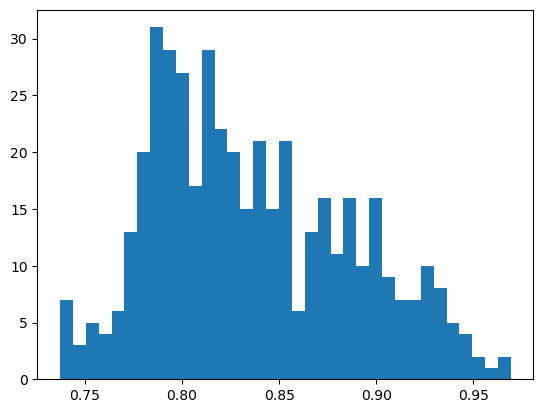

In [74]:
import matplotlib.pyplot as plt

plt.hist(q_ling_arr_l_n, bins=35)
#plt.hist(f_ling_arr_l_n, bins=25)

(array([ 2.,  2.,  4.,  1.,  2.,  3., 13.,  5., 10., 20., 24., 30., 52.,
        56., 65., 60., 49., 30., 14.,  6.]),
 array([0.92219108, 0.92516877, 0.92814645, 0.93112414, 0.93410183,
        0.93707952, 0.9400572 , 0.94303489, 0.94601258, 0.94899026,
        0.95196795, 0.95494564, 0.95792333, 0.96090101, 0.9638787 ,
        0.96685639, 0.96983408, 0.97281176, 0.97578945, 0.97876714,
        0.98174483]),
 [<matplotlib.patches.Polygon at 0x7fb4ce7fbdf0>])

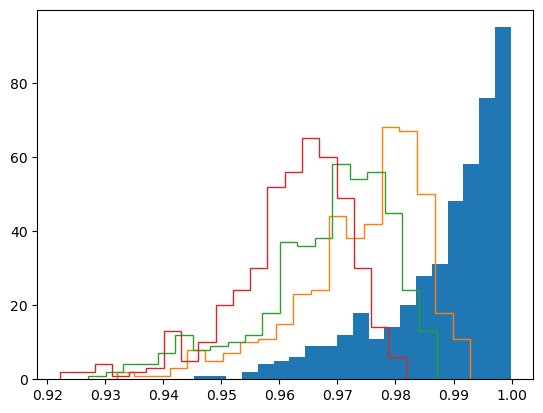

In [75]:
plt.hist(ent_d_l_n[0], bins=20)
plt.hist(ent_d_l_n[1], bins=20, histtype='step')
plt.hist(ent_d_l_n[2], bins=20, histtype='step')
plt.hist(ent_d_l_n[3], bins=20, histtype='step')
#plt.hist(ent_d_l_n[4], bins=25, histtype='step')
#plt.hist(ent_d_l_n[5], bins=25, histtype='step')

In [25]:
from scipy.stats import bootstrap
import numpy as np
data_l_n = (q_ling_arr_l_n, )
data_l_l_n = (f_ling_arr_l_n, )
res_l_n = bootstrap(data_l_n, np.mean, method= 'bca', confidence_level = 0.9)
res_long_l_n = bootstrap(data_l_l_n, np.mean, method= 'bca', confidence_level = 0.9)

In [77]:
res_l_n

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.8325473757873734, high=0.8405082510333663), bootstrap_distribution=array([0.84069562, 0.83913174, 0.84068402, ..., 0.83359178, 0.83804461,
       0.83857291]), standard_error=0.002411510549078074)

In [78]:
res_long_l_n

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896525524544642, high=0.9908039453638704), bootstrap_distribution=array([0.9902365 , 0.98962434, 0.98978942, ..., 0.99008048, 0.99063471,
       0.99001861]), standard_error=0.000347895084738024)

In [26]:
ent_len = [len(v) for v in ent_d.values()]
ent_bs_l_n = {}
for k,v in ent_d_l_n.items():
    data = (f_ling_arr_l_n, )
    res = bootstrap(data, np.mean, confidence_level = 0.9)
    ent_bs_l_n[k] = res
    if k == 10:
        break

In [82]:
ent_bs_l_n

{0: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896811654020039, high=0.9907889385794446), bootstrap_distribution=array([0.98953044, 0.9896028 , 0.99034968, ..., 0.99058174, 0.99044468,
        0.98988731]), standard_error=0.0003381679258253328),
 1: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896622201893474, high=0.9907880642903246), bootstrap_distribution=array([0.99049125, 0.99059815, 0.99022811, ..., 0.99111423, 0.99054973,
        0.99013688]), standard_error=0.0003417287729111649),
 2: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9896856301837608, high=0.990792282401119), bootstrap_distribution=array([0.9901254 , 0.99067981, 0.99059096, ..., 0.99041004, 0.98979486,
        0.98960036]), standard_error=0.0003361617673867475),
 3: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.989646892873627, high=0.9907725095083182), bootstrap_distribution=array([0.98981984, 0.99044365, 0.9901242 , ..., 0.99061908, 0.99103693,
   

# И повторим для белков. Так же отберём случайные 450 белков и вычислим их сложность

In [ ]:
from random import sample 

data_path = '/Volumes/chuudisuko/0cyto/геном человека/GCF_000001405.40_GRCh38.p14_protein.faa'

with open(data_path, 'r') as f:
    r = f.read()
    p_r = r.split('>')

sel_genes = sample(p_r[1:], 450)

fin_amyn_glob = {}
for n, gene in enumerate(sel_genes):
    g_ind = gene.find('\n')
    nucl = gene[(g_ind+1):].replace('\n', '')
    fin_amyn_glob[n] = nucl

d_out = d_out_gen(fin_amyn_glob)

In [ ]:
import pickle

with open('/Users/watashicuvu/Downloads/prot_gen_450_data.pkl', 'wb') as f:
    pickle.dump(d_out, f)

In [28]:
import pickle

with open('/Users/watashicuvu/Downloads/pkl-data/all_genome/prot_gen_450_data.pkl', 'rb') as f:
    d_out = pickle.load(f)

In [29]:
ent_d_p = {}
q_ling_arr_p = []
f_ling_arr_p = []
for vals in d_out.values():
    q_ling_arr_p.append(vals['q_ling_comp'])
    f_ling_arr_p.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_p:
            ent_d_p[n] = []
        ent_d_p[n].append(e)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   2.,   0.,   2.,   2.,   1.,   2.,   5.,  10.,  20.,  37.,
         72., 138., 157.]),
 array([0.74507197, 0.75518528, 0.76529859, 0.7754119 , 0.78552521,
        0.79563852, 0.80575183, 0.81586514, 0.82597845, 0.83609175,
        0.84620506, 0.85631837, 0.86643168, 0.87654499, 0.8866583 ,
        0.89677161, 0.90688492, 0.91699823, 0.92711153, 0.93722484,
        0.94733815, 0.95745146, 0.96756477, 0.97767808, 0.98779139,
        0.9979047 ]),
 <BarContainer object of 25 artists>)

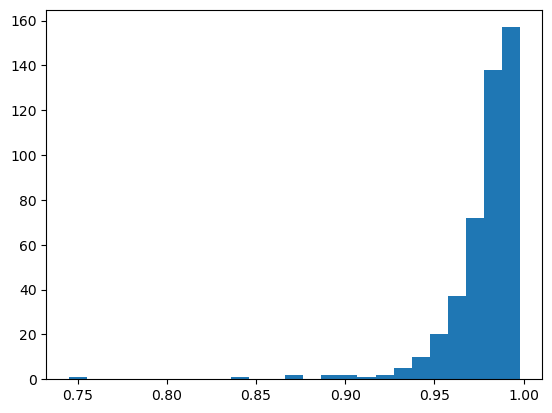

In [ ]:
import matplotlib.pyplot as plt

#plt.hist(q_ling_arr_p, bins=35)
plt.hist(f_ling_arr_p, bins=25)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,
          0.,   1.,   5.,   1.,   2.,   4.,   6.,  12., 410.]),
 array([0.8781857 , 0.88427641, 0.89036713, 0.89645784, 0.90254856,
        0.90863927, 0.91472999, 0.9208207 , 0.92691142, 0.93300213,
        0.93909285, 0.94518356, 0.95127428, 0.95736499, 0.96345571,
        0.96954642, 0.97563714, 0.98172785, 0.98781857, 0.99390928,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x7fb4de69e5e0>])

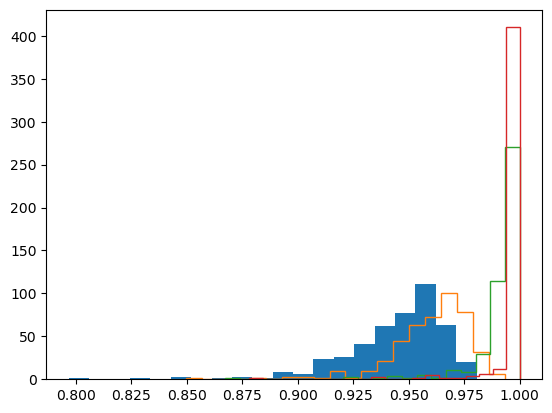

In [ ]:
plt.hist(ent_d_p[0], bins=20)
plt.hist(ent_d_p[1], bins=20, histtype='step')
plt.hist(ent_d_p[2], bins=20, histtype='step')
plt.hist(ent_d_p[3], bins=20, histtype='step')

In [30]:
from scipy.stats import bootstrap
import numpy as np
data_p = (q_ling_arr_p, )
data_l_p = (f_ling_arr_p, )
res_p = bootstrap(data_p, np.mean, method= 'bca', confidence_level = 0.9)
res_long_p = bootstrap(data_l_p, np.mean, method= 'bca', confidence_level = 0.9)

In [ ]:
res_p

BootstrapResult(confidence_interval=ConfidenceInterval(low=1.1630702710725558, high=1.1808984355516614), bootstrap_distribution=array([1.17272694, 1.16497652, 1.16481636, ..., 1.1732212 , 1.17024431,
       1.17329667]), standard_error=0.005418178746300355)

In [ ]:
res_long_p

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.977791469733481, high=0.9811112356275263), bootstrap_distribution=array([0.98093976, 0.9802168 , 0.98095234, ..., 0.98114061, 0.97975229,
       0.98017065]), standard_error=0.0009844775764847734)

In [96]:
ent_bs_p = {}
for k,v in ent_d_p.items():
    data = (f_ling_arr_p, )
    res = bootstrap(data, np.mean, confidence_level = 0.9)
    ent_bs_p[k] = res
    if k == 10:
        break

In [ ]:
ent_bs_p

{0: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9777536374379684, high=0.9810397399297893), bootstrap_distribution=array([0.98079836, 0.97926422, 0.9795762 , ..., 0.98133637, 0.97960102,
        0.97933319]), standard_error=0.0009735337075814043),
 1: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9777588612297227, high=0.9810465403247572), bootstrap_distribution=array([0.98136337, 0.97934881, 0.97947617, ..., 0.97810906, 0.98100548,
        0.9805779 ]), standard_error=0.0009801420999124724),
 2: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9777811573052265, high=0.9810640272855152), bootstrap_distribution=array([0.98083286, 0.98209135, 0.98082268, ..., 0.97974284, 0.97962951,
        0.98020979]), standard_error=0.0009769923292146981),
 3: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9777528551091972, high=0.981078382208682), bootstrap_distribution=array([0.98055505, 0.97955157, 0.97952582, ..., 0.97869526, 0.98003694,
  

И применим алгоритм для экспериментальной выборки

In [31]:
import pickle
with open('/Users/watashicuvu/Downloads/pkl-data/union/prot_union/short_iso_prot_union_data.pkl','rb') as f:
    d_n_sh = pickle.load(f)

with open('/Users/watashicuvu/Downloads/pkl-data/union/prot_union/long_iso_prot_union_data.pkl','rb') as f:
    d_n_l = pickle.load(f)

In [32]:
ent_d_sh = {}
q_ling_arr_sh = []
f_ling_arr_sh = []
for vals in d_n_sh.values():
    q_ling_arr_sh.append(vals['q_ling_comp'])
    f_ling_arr_sh.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_sh:
            ent_d_sh[n] = []
        ent_d_sh[n].append(e)

In [33]:
ent_d_l = {}
q_ling_arr_l = []
f_ling_arr_l = []
for vals in d_n_l.values():
    q_ling_arr_l.append(vals['q_ling_comp'])
    f_ling_arr_l.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_l:
            ent_d_l[n] = []
        ent_d_l[n].append(e)

(array([ 3.,  0.,  1.,  0.,  0.,  1.,  0.,  5.,  8., 10., 15., 18., 21.,
        23., 46., 32., 34., 31., 31., 23., 26., 26., 17., 16., 12., 20.,
         8.,  7.,  3.,  3.,  3.,  3.,  1.,  1.,  1.]),
 array([0.79187817, 0.8122036 , 0.83252902, 0.85285444, 0.87317986,
        0.89350529, 0.91383071, 0.93415613, 0.95448156, 0.97480698,
        0.9951324 , 1.01545782, 1.03578325, 1.05610867, 1.07643409,
        1.09675952, 1.11708494, 1.13741036, 1.15773578, 1.17806121,
        1.19838663, 1.21871205, 1.23903748, 1.2593629 , 1.27968832,
        1.30001374, 1.32033917, 1.34066459, 1.36099001, 1.38131544,
        1.40164086, 1.42196628, 1.44229171, 1.46261713, 1.48294255,
        1.50326797]),
 <BarContainer object of 35 artists>)

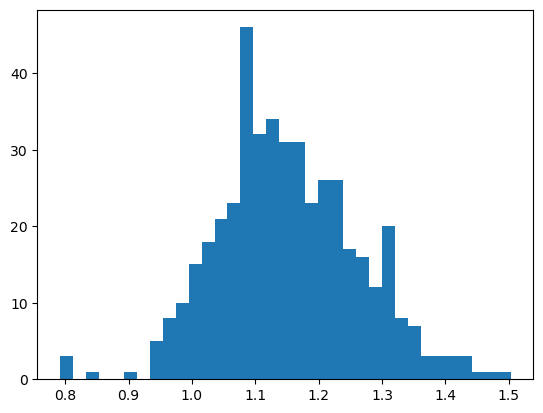

In [ ]:
import matplotlib.pyplot as plt

plt.hist(q_ling_arr_sh, bins=35)
#plt.hist(f_ling_arr_sh, bins=25)

(array([ 1.,  2.,  1.,  0.,  0.,  0.,  1.,  5.,  4.,  6., 17., 12., 21.,
        28., 21., 38., 33., 32., 34., 32., 11., 29., 28., 19., 13., 10.,
        13., 12.,  9.,  5.,  5.,  1.,  2.,  2.,  2.]),
 array([0.79187817, 0.81114123, 0.83040429, 0.84966735, 0.86893041,
        0.88819347, 0.90745653, 0.92671959, 0.94598265, 0.96524571,
        0.98450877, 1.00377183, 1.02303489, 1.04229795, 1.06156101,
        1.08082407, 1.10008713, 1.11935019, 1.13861325, 1.15787631,
        1.17713937, 1.19640243, 1.21566549, 1.23492855, 1.25419161,
        1.27345467, 1.29271773, 1.31198079, 1.33124385, 1.35050691,
        1.36976997, 1.38903303, 1.40829609, 1.42755915, 1.44682221,
        1.46608527]),
 <BarContainer object of 35 artists>)

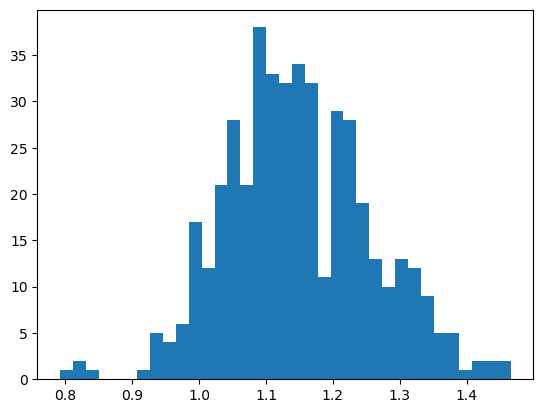

In [ ]:
import matplotlib.pyplot as plt

plt.hist(q_ling_arr_l, bins=35)
#plt.hist(f_ling_arr_l, bins=25)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   1.,   3.,   0.,   1.,   5.,  14., 408.]),
 array([0.9376204 , 0.94073938, 0.94385836, 0.94697734, 0.95009632,
        0.9532153 , 0.95633428, 0.95945326, 0.96257224, 0.96569122,
        0.9688102 , 0.97192918, 0.97504816, 0.97816714, 0.98128612,
        0.9844051 , 0.98752408, 0.99064306, 0.99376204, 0.99688102,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x7fb54a6d4130>])

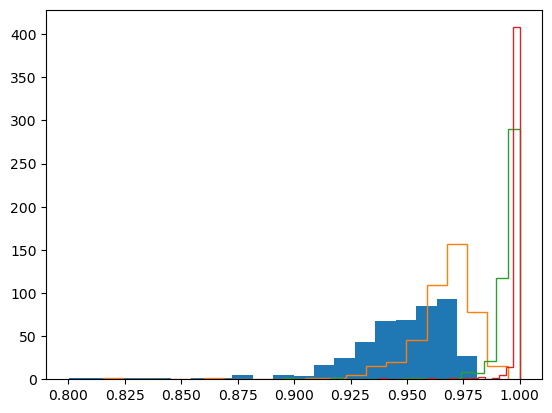

In [ ]:
plt.hist(ent_d_sh[0], bins=20)
plt.hist(ent_d_sh[1], bins=20, histtype='step')
plt.hist(ent_d_sh[2], bins=20, histtype='step')
plt.hist(ent_d_sh[3], bins=20, histtype='step')
#plt.hist(ent_d_sh[4], bins=25, histtype='step')
#plt.hist(ent_d_sh[5], bins=25, histtype='step')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          0.,   1.,   1.,   3.,   0.,   0.,   4.,  16., 408.]),
 array([0.9376204 , 0.94073938, 0.94385836, 0.94697734, 0.95009632,
        0.9532153 , 0.95633428, 0.95945326, 0.96257224, 0.96569122,
        0.9688102 , 0.97192918, 0.97504816, 0.97816714, 0.98128612,
        0.9844051 , 0.98752408, 0.99064306, 0.99376204, 0.99688102,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x7fb4df7e6f40>])

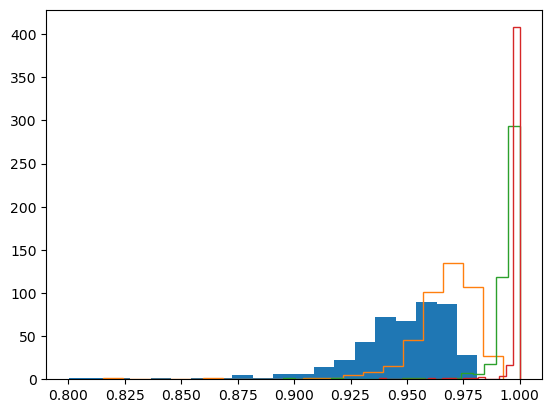

In [ ]:
plt.hist(ent_d_l[0], bins=20)
plt.hist(ent_d_l[1], bins=20, histtype='step')
plt.hist(ent_d_l[2], bins=20, histtype='step')
plt.hist(ent_d_l[3], bins=20, histtype='step')
#plt.hist(ent_d_l[4], bins=25, histtype='step')
#plt.hist(ent_d_l[5], bins=25, histtype='step')

In [34]:
from scipy.stats import bootstrap
import numpy as np
data = (q_ling_arr_sh, )
data_l = (f_ling_arr_sh, )
res_sh = bootstrap(data, np.mean, method= 'bca', confidence_level = 0.9)
res_long_sh = bootstrap(data_l, np.mean, method= 'bca', confidence_level = 0.9)

In [35]:
from scipy.stats import bootstrap
import numpy as np
data = (q_ling_arr_l, )
data_l = (f_ling_arr_l, )
res_l = bootstrap(data, np.mean, method= 'bca', confidence_level = 0.9)
res_long_l = bootstrap(data_l, np.mean, method= 'bca', confidence_level = 0.9)

In [ ]:
res_sh

BootstrapResult(confidence_interval=ConfidenceInterval(low=1.1434583171033907, high=1.160480748663942), bootstrap_distribution=array([1.15163801, 1.15806671, 1.16022238, ..., 1.14916003, 1.15523168,
       1.15279522]), standard_error=0.005192290032800082)

In [ ]:
res_l

BootstrapResult(confidence_interval=ConfidenceInterval(low=1.139963709148613, high=1.1569442347330428), bootstrap_distribution=array([1.15036977, 1.14281493, 1.14735809, ..., 1.14765017, 1.15044867,
       1.15087283]), standard_error=0.005129864837253302)

In [ ]:
res_long_sh

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9732570684209756, high=0.976604749790783), bootstrap_distribution=array([0.97562066, 0.97417266, 0.97518737, ..., 0.97420861, 0.97501947,
       0.97621207]), standard_error=0.001005071890733441)

In [ ]:
res_long_l

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9722494124394297, high=0.9756763474585395), bootstrap_distribution=array([0.97464486, 0.97258028, 0.97517992, ..., 0.97560574, 0.97401247,
       0.97486775]), standard_error=0.0010367173209614076)

In [86]:
ent_bs_sh = {}
for k,v in ent_d_sh.items():
    data = (f_ling_arr_sh, )
    res = bootstrap(data, np.mean, confidence_level = 0.9)
    ent_bs_sh[k] = res
    if k == 10:
        break

In [87]:
ent_bs_sh

{0: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9733699703350194, high=0.976637677127201), bootstrap_distribution=array([0.97544227, 0.9752041 , 0.97306786, ..., 0.97596591, 0.97407037,
        0.97378422]), standard_error=0.001002587229879316),
 1: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9732406467481571, high=0.976594439657807), bootstrap_distribution=array([0.9746574 , 0.97523133, 0.975331  , ..., 0.97683572, 0.97564849,
        0.97467708]), standard_error=0.0010092398332490332),
 2: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9733317513254603, high=0.9766143091762822), bootstrap_distribution=array([0.97427921, 0.97408839, 0.97604725, ..., 0.97527479, 0.97377281,
        0.97483386]), standard_error=0.0009925750566466495),
 3: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9733086995901394, high=0.9766258391822391), bootstrap_distribution=array([0.97597937, 0.97602282, 0.9725114 , ..., 0.97544464, 0.97350498,
    

In [94]:
ent_bs_l = {}
for k,v in ent_d_l.items():
    data = (f_ling_arr_l, )
    res = bootstrap(data, np.mean, confidence_level = 0.9)
    ent_bs_l[k] = res
    if k == 10:
        break

In [ ]:
ent_bs_l

{0: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.972186656144819, high=0.9756998718559144), bootstrap_distribution=array([0.97453278, 0.97386571, 0.97465779, ..., 0.97436381, 0.97246132,
        0.97535832]), standard_error=0.001055609352078462),
 1: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9722337830329942, high=0.9756749339923823), bootstrap_distribution=array([0.9722929 , 0.97398129, 0.97357067, ..., 0.97430802, 0.97555563,
        0.97409782]), standard_error=0.0010366304889907238),
 2: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9722240438593721, high=0.9757182030690734), bootstrap_distribution=array([0.97409935, 0.9733668 , 0.9749571 , ..., 0.975432  , 0.97574342,
        0.97343716]), standard_error=0.0010512529743694787),
 3: BootstrapResult(confidence_interval=ConfidenceInterval(low=0.972255756700872, high=0.9757010179442713), bootstrap_distribution=array([0.97303148, 0.97335803, 0.97516733, ..., 0.97527544, 0.9755674 ,
    

Проверка с помощью бутстрапа; ещё стоит Уилкоксону (или Манна-Уитни)

EFRON Band TIBSHIRANI R. J. An introduction to the bootstrap. – 1993.

In [40]:
import numpy as np

def bs_test(x,y,N=1000):
    z = x+y
    x, y = np.array(x), np.array(y)
    n, m = len(x), len(y)
    x_m, y_m = np.mean(x), np.mean(y)
    x_cap, y_cap = np.full((n), x_m), np.full((m), y_m)
    var_x, var_y = np.var(x), np.var(y)
    t = (x_m - y_m) / ((var_x/n + var_y/m)**0.5)
    x_point = x - x_cap + np.full((n), np.mean(z))
    y_point = y - y_cap + np.full((m), np.mean(z))
    t_stars = []
    for _ in range(N):
        x_star = np.random.choice(x_point, size=n)
        y_star = np.random.choice(y_point, size=m)
        x_m, y_m = np.mean(x_star), np.mean(y_star)
        var_x, var_y = np.var(x), np.var(y)
        t_star = (x_m - y_m) / ((var_x/n + var_y/m)**0.5)
        t_stars.append(t_star)
    p = [1 if t_s >= t else 0 for t_s in t_stars ]
    return (sum(p))/N

In [3]:
x = [0.9376204 , 0.94073938, 0.94385836, 0.94697734, 0.95009632,
        0.9532153 , 0.95633428, 0.95945326, 0.96257224, 0.96569122,
        0.9688102 , 0.97192918, 0.97504816, 0.97816714, 0.98128612,
        0.9844051 , 0.98752408, 0.99064306, 0.99376204, 0.99688102,
        1.        ]
y = [0.92219108, 0.92522133, 0.92825158, 0.93128183, 0.93431209,
        0.93734234, 0.94037259, 0.94340284, 0.94643309, 0.94946335,
        0.9524936 , 0.95552385, 0.9585541 , 0.96158436, 0.96461461,
        0.96764486, 0.97067511, 0.97370536, 0.97673562, 0.97976587,
        0.98279612]

z = [0.92219108, 0.92522133, 0.92825158, 0.93128183, 0.93431209,
        0.93734234, 0.94037259, 0.94340284, 0.94643309, 0.94946335,
        0.9524936 , 0.95552385, 0.9585541 , 0.96158436, 0.96461461,
        0.96764486, 0.97067511, 0.97370536, 0.97673562, 0.97976587,
        0.98279612]


In [149]:
p = bs_test(x,y)
p

0.004

In [4]:
#from scipy.stats import wilcoxon
#res = wilcoxon(x, y, alternative='greater')
# манна-уитни лучше с поправкой; либо БС

from scipy import stats
stats.kruskal(x, y, z)

KruskalResult(statistic=8.592979097841889, pvalue=0.013616274477228532)

In [97]:
# для сравнения БС распределений 
res_l_l = {'genes':{'sh': res.bootstrap_distribution, 
                    'l': res_l_n.bootstrap_distribution, 
                    'gen': res_g.bootstrap_distribution}, 
          'proteins': {'sh': res_sh.bootstrap_distribution, 
                       'l': res_l.bootstrap_distribution, 
                       'gen': res_p.bootstrap_distribution}}
res_l_l_l = {'genes': {'sh': res_l.bootstrap_distribution, 
                       'l': res_long_l_n.bootstrap_distribution, 
                       'gen': res_long_g.bootstrap_distribution}, 
          'proteins': {'sh': res_long_sh.bootstrap_distribution, 
                       'l': res_long_l.bootstrap_distribution, 
                       'gen': res_long_p.bootstrap_distribution}}
ent_l_0 = {'genes': {'sh': ent_bs[0].bootstrap_distribution, 
                   'l': ent_bs_l_n[0].bootstrap_distribution, 
                   'gen': ent_bs_g[0].bootstrap_distribution}, 
          'proteins': {'sh': ent_bs_sh[0].bootstrap_distribution, 
                       'l': ent_bs_l[0].bootstrap_distribution, 
                       'gen': ent_bs_p[0].bootstrap_distribution}}
ent_l_1 = {'genes': {'sh': ent_bs[1].bootstrap_distribution, 
                   'l': ent_bs_l_n[1].bootstrap_distribution, 
                   'gen': ent_bs_g[1].bootstrap_distribution}, 
          'proteins': {'sh': ent_bs_sh[1].bootstrap_distribution, 
                       'l': ent_bs_l[1].bootstrap_distribution, 
                       'gen': ent_bs_p[1].bootstrap_distribution}}
ent_l_2 = {'genes': {'sh': ent_bs[2].bootstrap_distribution, 
                   'l': ent_bs_l_n[2].bootstrap_distribution, 
                   'gen': ent_bs_g[2].bootstrap_distribution}, 
          'proteins': {'sh': ent_bs_sh[2].bootstrap_distribution, 
                       'l': ent_bs_l[2].bootstrap_distribution, 
                       'gen': ent_bs_p[2].bootstrap_distribution}}

In [ ]:
# Для сравнения самих распределений

res_l_l = {'genes':{'sh': q_ling_arr_sh_g, 
                    'l': q_ling_arr_l_n, 
                    'gen': q_ling_arr_g}, 
          'proteins': {'sh': q_ling_arr_sh, 
                       'l': q_ling_arr_l, 
                       'gen': q_ling_arr_p}}
res_l_l_l = {'genes': {'sh': f_ling_arr_sh_g, 
                       'l': f_ling_arr_l_n, 
                       'gen': f_ling_arr_g}, 
          'proteins': {'sh': f_ling_arr_sh, 
                       'l': f_ling_arr_l, 
                       'gen': f_ling_arr_p}}
ent_l = {'genes': {'sh': ent_d_g[0], 
                   'l': ent_d_l_n[0], 
                   'gen': ent_d_g[0]}, 
          'proteins': {'sh': ent_d_sh[0], 
                       'l': ent_d_l[0], 
                       'gen': ent_d_p[0]}}
ent_l_1 = {'genes': {'sh': ent_d_g[1], 
                   'l': ent_d_l_n[1], 
                   'gen': ent_d_g[1]}, 
          'proteins': {'sh': ent_d_sh[1], 
                       'l': ent_d_l[1], 
                       'gen': ent_d_p[1]}}
ent_l_2 = {'genes': {'sh': ent_d_g[2], 
                   'l': ent_d_l_n[2], 
                   'gen': ent_d_g[2]}, 
          'proteins': {'sh': ent_d_sh[2], 
                       'l': ent_d_l[2], 
                       'gen': ent_d_p[2]}}

In [101]:
from scipy import stats

stat_f = [bs_test, stats.mannwhitneyu]
stat_f = stat_f[0]
res_l_t = {'genes' : [], 'proteins' : []}
res_l_l_t = {'genes' : [], 'proteins' : []}
ent_l_0_t = {'genes' : [], 'proteins' : []}
ent_l_1_t = {'genes' : [], 'proteins' : []}
ent_l_2_t = {'genes' : [], 'proteins' : []}
legend_g = ('Гены генеральной совокупности - короткие изоформы', 
          'Гены генеральной совокупности - длинные изоформы')
legend_p = ('Белки генеральной совокупности - короткие изоформы', 
          'Белки генеральной совокупности - длинные изоформы')
legend = ('Лингвистическая сложность укороченная', 'Лингвистическая сложность', 
           'Энтропия 1 символа', 'Энтропия 2 символов', 'Энтропия 3 символов')

for metric, table in zip([res_l_l, res_l_l_l, ent_l, ent_l_1, ent_l_2], 
                         [res_l_t, res_l_l_t, ent_l_0_t, ent_l_1_t, ent_l_2_t]):
    gg_sh = stat_f(metric['genes']['sh'], metric['genes']['gen'])
    gg_l = stat_f(metric['genes']['l'], metric['genes']['gen'])
    gp_sh = stat_f(metric['proteins']['sh'], metric['proteins']['gen'])
    gp_l = stat_f(metric['proteins']['l'], metric['proteins']['gen'])
    table['genes'] = [gg_sh, gg_l]
    table['proteins'] = [gp_sh, gp_l]

# перевести в ДФ и добавить столбец-легенду

Необходимо так же посмотреть матрицу ошибок для модели, основанной на ДИ сложности при определении генов, ответственных за амилоидные заболевания (в идеале сравнить бы с применяемыми практиками типа GC состава, но их ещё найти надо)

In [102]:
import pandas as pd
t_g = pd.DataFrame({'-':legend_g, legend[0]:res_l_t['genes'], 
                    legend[1]:res_l_l_t['genes'], legend[2]:ent_l_0_t['genes'], 
                    legend[3]:ent_l_1_t['genes'], legend[4]:ent_l_2_t['genes']})
p_g = pd.DataFrame({'-':legend_p, legend[0]:res_l_t['proteins'], 
                    legend[1]:res_l_l_t['proteins'], legend[2]:ent_l_0_t['proteins'], 
                    legend[3]:ent_l_1_t['proteins'], legend[4]:ent_l_2_t['proteins']})

In [72]:
t_g

,-,Лингвистическая сложность укороченная,Лингвистическая сложность,Энтропия 1 символа,Энтропия 2 символов,Энтропия 3 символов
0,Гены генеральной совокупности - короткие изоформы,"(100352.0, 1.0)","(100352.0, 1.0)","(100352.0, 1.0)","(100352.0, 1.0)","(100352.0, 1.0)"
1,Гены генеральной совокупности - длинные изоформы,"(96378.5, 0.3050164628062261)","(97936.5, 0.5329585194567323)","(100995.5, 0.8681510727884767)","(99987.5, 0.9251280356442729)","(98350.5, 0.6054276579636906)"


In [73]:
p_g

,-,Лингвистическая сложность укороченная,Лингвистическая сложность,Энтропия 1 символа,Энтропия 2 символов,Энтропия 3 символов
0,Белки генеральной совокупности - короткие изоф...,"(88962.5, 0.0019446652607979123)","(78889.5, 1.2992363556018903e-08)","(106241.0, 0.18031446449129684)","(128275.0, 2.559493785460044e-12)","(125985.5, 1.437477396238072e-10)"
1,Белки генеральной совокупности - длинные изоформы,"(88962.5, 0.0019446652607979123)","(78889.5, 1.2992363556018903e-08)","(106241.0, 0.18031446449129684)","(128275.0, 2.559493785460044e-12)","(125985.5, 1.437477396238072e-10)"


In [103]:
pd.DataFrame.to_csv(t_g, '/Users/watashicuvu/Downloads/bs_dist_genes_bs.csv')
pd.DataFrame.to_csv(p_g, '/Users/watashicuvu/Downloads/bs_dist_proteins_bs.csv')


# Далее построим матрицу ошибок для проверки ДИ на других генах. Для этого используем 90 генов, ассоцированных с амилоидной ангеопатией и 90 случайных генов из генеральной совокупности  (метод простой рандомизации)

In [1]:
# https://ctdbase.org/detail.go?acc=MESH%3AD000686&view=gene&page=1&type=disease
# Амилоидозы в целом (генов не так уж много, около 5000)
import pandas as pd

t_path = '/Users/watashicuvu/Downloads/таблицы для диплома/для приложения/angeopathy.csv'
t = pd.read_csv(t_path)
print(*t.loc[:,'Gene ID'].values)

отберём 90 белков

In [8]:
import pickle
from random import sample 

data_path = '/Volumes/chuudisuko/0cyto/геном человека/GCF_000001405.40_GRCh38.p14_protein.faa'

with open(data_path, 'r') as f:
    r = f.read()
    p_r = r.split('>')

sel_genes = sample(p_r[1:], 90)

fin_amyn_glob = {}
for n, gene in enumerate(sel_genes):
    g_ind = gene.find('\n')
    nucl = gene[(g_ind+1):].replace('\n', '')
    fin_amyn_glob[n] = nucl

d_out = d_out_gen(fin_amyn_glob)

with open('/Users/watashicuvu/Downloads/prot_gen_90_data.pkl', 'wb') as f:
    pickle.dump(d_out, f)

и 90 генов

In [24]:
import pickle

with open('/Users/watashicuvu/Downloads/pkl-data/all_genome/nucl_gen_3214_data.pkl', 'rb') as f:
    d = pickle.load(f)

ent_d_g = {}
q_ling_arr_g = []
f_ling_arr_g = []

sel_val = sample(list(d.values())[451:], 90)
for vals in sel_val:
    q_ling_arr_g.append(vals['q_ling_comp'])
    f_ling_arr_g.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_g:
            ent_d_g[n] = []
        ent_d_g[n].append(e)


In [26]:
with open('/Users/watashicuvu/Downloads/nucl_gen_90_complexity_data.pkl', 'wb') as f:
    pickle.dump(sel_val, f)

Если предварительно сохранить pickle файл (или из репозитория), можно в качестве альтернативы использовать код ниже

In [9]:
import pickle

ent_d_p = {}
q_ling_arr_p = []
f_ling_arr_p = []

with open('/Users/watashicuvu/Downloads/pkl-data/confussion_matrix/prot_gen_90_data.pkl', 'rb') as f:
    d_out = pickle.load(f)

for vals in d_out.values():
    q_ling_arr_p.append(vals['q_ling_comp'])
    f_ling_arr_p.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_p:
            ent_d_p[n] = []
        ent_d_p[n].append(e)

with open('/Users/watashicuvu/Downloads/pkl-data/confussion_matrix/nucl_gen_90_complexity_data.pkl', 'rb') as f:
    sel_val = pickle.load(f)

ent_d_g = {}
q_ling_arr_g = []
f_ling_arr_g = []

for vals in sel_val:
    q_ling_arr_g.append(vals['q_ling_comp'])
    f_ling_arr_g.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_g:
            ent_d_g[n] = []
        ent_d_g[n].append(e)

Выпишем получившиеся с помощью бутстрэп ДИ

In [22]:
# isoform (l,s), metric (l_q, l_g, e_0 - e_2), subject (g, p)
bs_dict = {'l_l_q_g' : [0.831, 0.843],
            's_l_q_g' : [0.833, 0.846],

            'l_l_l_g' : [0.989, 0.991],
            's_l_l_g' : [0.989, 0.991],

            'l_e_0_g' : [0.989, 0.991],
            's_e_0_g' : [0.989, 0.991],

            'l_e_1_g' : [0.989, 0.991],
            's_e_1_g' : [0.989, 0.991],

            'l_e_2_g' : [0.989, 0.991],
            's_e_2_g' : [0.989, 0.991],

            'l_l_q_p' : [1.134, 1.162],
            's_l_q_p' : [1.138, 1.654],

            'l_l_l_p' : [0.971, 0.977],
            's_l_l_p' : [0.972, 0.977],

            'l_e_0_p' : [0.971, 0.977],
            's_e_0_p' : [0.972, 0.978],

            'l_e_1_p' : [0.971, 0.977],
            's_e_1_p' : [0.972, 0.978],

            'l_e_2_p' : [0.971, 0.977],
            's_e_2_p' : [0.972, 0.978]}

далее импортируем белки и гены, ассоциированные с амилоидной ангиопатией

In [11]:
path_rna = '/Users/watashicuvu/Downloads/pkl-data/ncbi_dataset/ncbi_dataset/data/rna.fna'
path_prot = '/Users/watashicuvu/Downloads/pkl-data/ncbi_dataset/ncbi_dataset/data/protein.faa'

with open(path_rna, 'r') as f:
    r = f.read()
    s_r = r.split('>')
    
with open(path_prot, 'r') as f:
    r = f.read()
    p_r = r.split('>')

pr = cook_seq(p_r)
nuc = cook_seq(s_r)

iso_long_g, iso_short_g = long_short(nuc)
iso_long_p, iso_short_p = long_short(pr)

d_out_g_sh = d_out_gen(iso_short_g)
d_out_g_l = d_out_gen(iso_long_g)
d_out_p_sh = d_out_gen(iso_short_p)
d_out_p_l = d_out_gen(iso_long_p)

In [19]:
ent_d_g_sh_test = {}
q_ling_arr_g_sh_test = []
f_ling_arr_g_sh_test = []
for vals in d_out_g_sh.values():
    q_ling_arr_g_sh_test.append(vals['q_ling_comp'])
    f_ling_arr_g_sh_test.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_g_sh_test:
            ent_d_g_sh_test[n] = []
        ent_d_g_sh_test[n].append(e)

ent_d_g_l_test = {}
q_ling_arr_g_l_test = []
f_ling_arr_g_l_test = []
for vals in d_out_g_l.values():
    q_ling_arr_g_l_test.append(vals['q_ling_comp'])
    f_ling_arr_g_l_test.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_g_l_test:
            ent_d_g_l_test[n] = []
        ent_d_g_l_test[n].append(e)

ent_d_p_sh_test = {}
q_ling_arr_p_sh_test = []
f_ling_arr_p_sh_test = []
for vals in d_out_p_sh.values():
    q_ling_arr_p_sh_test.append(vals['q_ling_comp'])
    f_ling_arr_p_sh_test.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_p_sh_test:
            ent_d_p_sh_test[n] = []
        ent_d_p_sh_test[n].append(e)
    
ent_d_p_l_test = {}
q_ling_arr_p_l_test = []
f_ling_arr_p_l_test = []
for vals in d_out_p_l.values():
    q_ling_arr_p_l_test.append(vals['q_ling_comp'])
    f_ling_arr_p_l_test.append(vals['full_ling_comp'])
    ent_val = vals['ent']
    for n, e in enumerate(ent_val):
        if n not in ent_d_p_l_test:
            ent_d_p_l_test[n] = []
        ent_d_p_l_test[n].append(e)

In [20]:
def change_view(array, key, bs_dict=bs_dict):
    bs = bs_dict[key]
    new_array = [True if (el > bs[0] and el < bs[1]) else False for el in array]
    return new_array

raw_train_dict = {'l_l_q_g' : q_ling_arr_g + q_ling_arr_g_l_test  ,
            's_l_q_g' : q_ling_arr_g   + q_ling_arr_g_sh_test ,

            'l_l_l_g' : f_ling_arr_g   + f_ling_arr_g_l_test  ,
            's_l_l_g' : f_ling_arr_g   + f_ling_arr_g_sh_test ,

            'l_e_0_g' : ent_d_g[0]     + ent_d_g_l_test[0]    ,
            's_e_0_g' : ent_d_g[0]     + ent_d_g_sh_test[0]   ,

            'l_e_1_g' : ent_d_g[1]     + ent_d_g_l_test[1]    ,
            's_e_1_g' : ent_d_g[1]     + ent_d_g_sh_test[1]   ,

            'l_e_2_g' : ent_d_g[2]     + ent_d_g_l_test[2]    ,
            's_e_2_g' : ent_d_g[2]     + ent_d_g_sh_test[2]   ,

            'l_l_q_p' : q_ling_arr_p   + q_ling_arr_p_l_test  ,
            's_l_q_p' : q_ling_arr_p   + q_ling_arr_p_sh_test ,

            'l_l_l_p' : f_ling_arr_p   + f_ling_arr_p_l_test  ,
            's_l_l_p' : f_ling_arr_p   + f_ling_arr_p_sh_test ,

            'l_e_0_p' : ent_d_p[0]     + ent_d_p_l_test[0]    ,
            's_e_0_p' : ent_d_p[0]     + ent_d_p_sh_test[0]   ,

            'l_e_1_p' : ent_d_p[1]     + ent_d_p_l_test[1]    ,
            's_e_1_p' : ent_d_p[1]     + ent_d_p_sh_test[1]   ,

            'l_e_2_p' : ent_d_p[2]     + ent_d_p_l_test[2]    ,
            's_e_2_p' : ent_d_p[2]     + ent_d_p_sh_test[2]   }

train_dict = {}
for k, v in raw_train_dict.items():
    train_dict[k] = change_view(v, k)

In [22]:
test_dict = {'l_l_q_g' : [0]*len(q_ling_arr_g) + [1]*len(q_ling_arr_g_l_test ),
            's_l_q_g' : [0]*len(q_ling_arr_g) + [1]*len(q_ling_arr_g_sh_test),

            'l_l_l_g' : [0]*len(f_ling_arr_g) + [1]*len(f_ling_arr_g_l_test ),
            's_l_l_g' : [0]*len(f_ling_arr_g) + [1]*len(f_ling_arr_g_sh_test),

            'l_e_0_g' : [0]*len(ent_d_g[0]) + [1]*len(ent_d_g_l_test[0]   ),
            's_e_0_g' : [0]*len(ent_d_g[0]) + [1]*len(ent_d_g_sh_test[0]  ),

            'l_e_1_g' : [0]*len(ent_d_g[1]) + [1]*len(ent_d_g_l_test[1]   ),
            's_e_1_g' : [0]*len(ent_d_g[1]) + [1]*len(ent_d_g_sh_test[1]  ),

            'l_e_2_g' : [0]*len(ent_d_g[2]) + [1]*len(ent_d_g_l_test[2]   ),
            's_e_2_g' : [0]*len(ent_d_g[2]) + [1]*len(ent_d_g_sh_test[2]  ),

            'l_l_q_p' : [0]*len(q_ling_arr_p) + [1]*len(q_ling_arr_p_l_test ),
            's_l_q_p' : [0]*len(q_ling_arr_p) + [1]*len(q_ling_arr_p_sh_test),

            'l_l_l_p' : [0]*len(f_ling_arr_p) + [1]*len(f_ling_arr_p_l_test ),
            's_l_l_p' : [0]*len(f_ling_arr_p) + [1]*len(f_ling_arr_p_sh_test),

            'l_e_0_p' : [0]*len(ent_d_p[0]) + [1]*len(ent_d_p_l_test[0]   ),
            's_e_0_p' : [0]*len(ent_d_p[0]) + [1]*len(ent_d_p_sh_test[0]  ),

            'l_e_1_p' : [0]*len(ent_d_p[1]) + [1]*len(ent_d_p_l_test[1]   ),
            's_e_1_p' : [0]*len(ent_d_p[1]) + [1]*len(ent_d_p_sh_test[1]  ),

            'l_e_2_p' : [0]*len(ent_d_p[2]) + [1]*len(ent_d_p_l_test[2]   ),
            's_e_2_p' : [0]*len(ent_d_p[2]) + [1]*len(ent_d_p_sh_test[2]  ) }

In [23]:
from sklearn.metrics import confusion_matrix
# можно вычислить f1-score
confus_dict = {}
for k in train_dict:
    confus_dict[k] = confusion_matrix(test_dict[k], train_dict[k], labels=[True, False])

In [26]:
confus_dict

{'l_l_q_g': array([[ 0, 90],
        [ 0, 90]]),
 's_l_q_g': array([[ 9, 81],
        [ 3, 87]]),
 'l_l_l_g': array([[ 8, 82],
        [ 4, 86]]),
 's_l_l_g': array([[ 7, 83],
        [ 4, 86]]),
 'l_e_0_g': array([[ 9, 81],
        [ 4, 86]]),
 's_e_0_g': array([[ 6, 84],
        [ 4, 86]]),
 'l_e_1_g': array([[ 4, 86],
        [ 2, 88]]),
 's_e_1_g': array([[ 5, 85],
        [ 2, 88]]),
 'l_e_2_g': array([[ 0, 90],
        [ 0, 90]]),
 's_e_2_g': array([[ 0, 90],
        [ 0, 90]]),
 'l_l_q_p': array([[ 9, 81],
        [10, 80]]),
 's_l_q_p': array([[47, 43],
        [52, 38]]),
 'l_l_l_p': array([[ 9, 81],
        [ 5, 85]]),
 's_l_l_p': array([[ 5, 85],
        [ 4, 86]]),
 'l_e_0_p': array([[ 4, 86],
        [ 4, 86]]),
 's_e_0_p': array([[ 5, 85],
        [ 4, 86]]),
 'l_e_1_p': array([[21, 69],
        [15, 75]]),
 's_e_1_p': array([[19, 71],
        [14, 76]]),
 'l_e_2_p': array([[ 1, 89],
        [ 0, 90]]),
 's_e_2_p': array([[ 1, 89],
        [ 0, 90]])}

https://en.wikipedia.org/wiki/Sensitivity_and_specificity


https://en.wikipedia.org/wiki/Diagnostic_odds_ratio

In [14]:
name_dict = {'l_l_q_g' : 'Укороченная лингвистическая сложность длинных изоформ генов',
            's_l_q_g' : 'Укороченная лингвистическая сложность коротких изоформ генов',
            'l_l_l_g' : 'Лингвистическая сложность длинных изоформ генов',
            's_l_l_g' : 'Лингвистическая сложность коротких изоформ генов',
            'l_e_0_g' : 'Энтропия 1 символа в последовательности длинной изоформы гена',
            's_e_0_g' : 'Энтропия 1 символа в последовательности коротких изоформы гена',
            'l_e_1_g' : 'Энтропия 2 символов в последовательности длинной изоформы гена',
            's_e_1_g' : 'Энтропия 2 символов в последовательности коротких изоформы гена',
            'l_e_2_g' : 'Энтропия 3 символов в последовательности длинной изоформы гена',
            's_e_2_g' : 'Энтропия 3 символов в последовательности коротких изоформы гена',
            'l_l_q_p' : 'Укороченная лингвистическая сложность длинных изоформ белка',
            's_l_q_p' : 'Укороченная лингвистическая сложность коротких изоформ белка',
            'l_l_l_p' : 'Лингвистическая сложность длинных изоформ белка',
            's_l_l_p' : 'Лингвистическая сложность коротких изоформ белка',
            'l_e_0_p' : 'Энтропия 1 символа в последовательности длинной изоформы белка',
            's_e_0_p' : 'Энтропия 1 символа в последовательности коротких изоформы белка',
            'l_e_1_p' : 'Энтропия 2 символов в последовательности длинной изоформы белка',
            's_e_1_p' : 'Энтропия 2 символов в последовательности коротких изоформы белка',
            'l_e_2_p' : 'Энтропия 3 символов в последовательности длинной изоформы белка',
            's_e_2_p' :  'Энтропия 3 символов в последовательности коротких изоформы белка'}

In [2]:
import pickle
with open('/Users/watashicuvu/Downloads/confus_dict.pkl', 'rb') as f:
    confus_dict = pickle.load(f)

In [6]:
d_t = {'-': ['чувствительность', 'специфичность', 'диагностическое отношение шансов']}
for k, v in confus_dict.items():
    N = v[0][1]+v[1][1]
    recall = v[0][0]/N
    specifity = v[1][1]/N
    f_1 = 2*v[0][0]/(2*v[0][0]+v[0][1]+v[1][0])
    dor = recall*specifity/((1-specifity)*(1-recall))
    # dor must be greater than 1
    print(f'{name_dict[k]}: чувствительность - {recall}, специфичность - {specifity}, диагностическое отношение шансов - {dor}')
    d_t[name_dict[k]] = [recall, specifity, dor]

Укороченная лингвистическая сложность длинных изоформ генов: чувствительность - 0.0, специфичность - 0.5, диагностическое отношение шансов - 0.0
Укороченная лингвистическая сложность коротких изоформ генов: чувствительность - 0.05357142857142857, специфичность - 0.5178571428571429, диагностическое отношение шансов - 0.060796645702306085
Лингвистическая сложность длинных изоформ генов: чувствительность - 0.047619047619047616, специфичность - 0.5119047619047619, диагностическое отношение шансов - 0.0524390243902439
Лингвистическая сложность коротких изоформ генов: чувствительность - 0.04142011834319527, специфичность - 0.5088757396449705, диагностическое отношение шансов - 0.04477167930983193
Энтропия 1 символа в последовательности длинной изоформы гена: чувствительность - 0.05389221556886228, специфичность - 0.5149700598802395, диагностическое отношение шансов - 0.06047819971870604
Энтропия 1 символа в последовательности коротких изоформы гена: чувствительность - 0.03529411764705882, сп

Далее код для представления некоторых результатов в виде таблиц

In [7]:
import pandas as pd

t_d = pd.DataFrame(d_t)
pd.DataFrame.to_csv(t_d.transpose(), '/Users/watashicuvu/Downloads/diagnostic_ods.csv')

In [9]:
t_d.transpose()

,0,1,2
-,чувствительность,специфичность,диагностическое отношение шансов
Укороченная лингвистическая сложность длинных изоформ генов,0.0,0.5,0.0
Укороченная лингвистическая сложность коротких изоформ генов,0.053571,0.517857,0.060797
Лингвистическая сложность длинных изоформ генов,0.047619,0.511905,0.052439
Лингвистическая сложность коротких изоформ генов,0.04142,0.508876,0.044772
Энтропия 1 символа в последовательности длинной изоформы гена,0.053892,0.51497,0.060478
Энтропия 1 символа в последовательности коротких изоформы гена,0.035294,0.505882,0.037456
Энтропия 2 символов в последовательности длинной изоформы гена,0.022989,0.505747,0.024077
Энтропия 2 символов в последовательности коротких изоформы гена,0.028902,0.508671,0.030812
Энтропия 3 символов в последовательности длинной изоформы гена,0.0,0.5,0.0


In [27]:
ds_t = {'-': ['Нижняя граница ДИ', 'Верхняя граница ДИ']}
for k, v in bs_dict.items():
    ds_t[name_dict[k]] = v
t_ds = pd.DataFrame(ds_t)
pd.DataFrame.to_csv(t_ds.transpose(), '/Users/watashicuvu/Downloads/bs_ei.csv')

In [29]:
t_ds.transpose()

,0,1
-,Нижняя граница ДИ,Верхняя граница ДИ
Укороченная лингвистическая сложность длинных изоформ генов,0.831,0.843
Укороченная лингвистическая сложность коротких изоформ генов,0.833,0.846
Лингвистическая сложность длинных изоформ генов,0.989,0.991
Лингвистическая сложность коротких изоформ генов,0.989,0.991
Энтропия 1 символа в последовательности длинной изоформы гена,0.989,0.991
Энтропия 1 символа в последовательности коротких изоформы гена,0.989,0.991
Энтропия 2 символов в последовательности длинной изоформы гена,0.989,0.991
Энтропия 2 символов в последовательности коротких изоформы гена,0.989,0.991
Энтропия 3 символов в последовательности длинной изоформы гена,0.989,0.991
